I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [13]:
from pearce.emulator import *
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [14]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [15]:
from GPy.models import GPKroneckerGaussianRegression
from GPy.kern import *
import h5py

In [16]:
training_file = '/home/users/swmclau2/scratch/xi_gg_zheng07_cosmo_v3/PearceXiggCosmo.hdf5'
test_file = '/home/users/swmclau2/scratch/xi_gg_zheng07_cosmo_test_v3/PearceXiggCosmoTest.hdf5'

In [18]:
accs = []
for rbin in xrange(18):

    f = h5py.File(training_file, 'r')

    Ys = []
    for i in xrange(40):
        Ys.append(f['cosmo_no_%02d'%i]['a_1.000']['obs'].value[:, rbin])

    n_hods = 500
    start_idx = 0
    X1 = f.attrs['cosmo_param_vals']
    X2 = f.attrs['hod_param_vals'][start_idx:start_idx+n_hods]
    Y = np.vstack(Ys)[:, start_idx:start_idx+n_hods]

    f.close()
    # how to add training errors?

    K1 =RBF(input_dim=7, ARD = False)+ Linear(input_dim = 7, ARD = False) + Bias(input_dim=7)# + White(input_dim=7)
    K2 =  RBF(input_dim=4, ARD = False)#+ Linear(input_dim = 4, ARD = False) + Bias(input_dim=4)# + White(input_dim=4)

    model = GPKroneckerGaussianRegression(X1, X2, Y,K1, K2)#, noise_var = 0.01 )

    model.optimize_restarts(num_restarts=10, verbose = False)

    print K1.param_array
    print K2.param_array
    print 
    
    f2 = h5py.File(test_file, 'r')

    Y2s = []
    for i in xrange(35):
        Y2s.append(f2['cosmo_no_%02d'%i]['a_1.000']['obs'].value[:, rbin])

    testX1 = f2.attrs['cosmo_param_vals']
    testX2 = f2.attrs['hod_param_vals'][:100]
    testY = np.vstack(Y2s)[:, :100]
    f2.close()

    predY, _ = model.predict(testX1, testX2)
    med_acc, mean_acc = np.median( np.abs( (10**predY[:,0] - 10**testY.flatten(order='F'))/10**testY.flatten(order='F') )  ), \
np.mean( np.abs( (10**predY[:,0] - 10**testY.flatten(order='F'))/10**testY.flatten(order='F') )  ) 
    print rbin, med_acc, mean_acc
    accs.append((med_acc, mean_acc))
    print

[ 0.0082304   0.2251038   0.40789898  2.16662866]
[ 2.3342071   0.83936984]

0 0.0468039238945 0.142320731167

[ 0.01843742  0.23593541  0.72105056  5.40140803]
[ 1.09977674  0.83752504]

1 0.0491633329039 0.133636639761

[ 0.00852149  0.23091239  0.36093694  3.75689519]
[ 2.59171998  0.84863244]

2 0.0531361443795 0.120512094339

[ 0.01301592  0.22714714  0.38110864  4.62012707]
[ 1.43396165  0.79431016]

3 0.0534848551322 0.110295680064

[ 0.01485354  0.21519457  0.29666937  4.95945163]
[ 1.07388838  0.74296391]

4 0.0592939878066 0.101115460134

[ 0.02153361  0.22013727  0.40101137  4.63757503]
[ 0.74628684  0.71849977]

5 0.0577103878551 0.0939222399656

[  1.08761721e-01   2.20555446e-01   1.54365595e-03   6.20290816e+00]
[ 0.14097065  0.56007477]

6 0.102980965329 0.141328865636

[ 0.01917612  0.20171018  0.56261425  2.05092433]
[ 0.18642131  0.5630406 ]

7 0.0301304913085 0.0617151312434

[ 0.01144216  0.19538761  0.56102256  1.95472784]
[ 0.20359536  0.5520345 ]

8 0.0237009266

In [19]:
accs = np.array(accs)

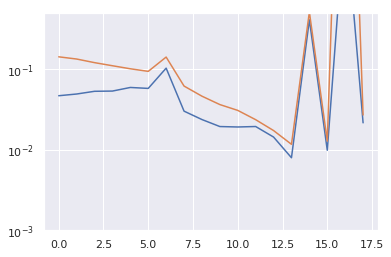

In [20]:
plt.plot(accs)
plt.ylim([0.001, 0.5])
plt.yscale('log')